In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from netCDF4 import Dataset
# from skimage import transform
from plot_picture_function import set_map_ticks,add_Chinese_provinces
from datetime import timedelta
import cartopy.crs as ccrs

from scipy import stats

In [3]:
import glob

In [29]:
dataJRA55_CLW

<xarray.Dataset>
Dimensions:                (initial_time0_hours: 125, forecast_time1: 2,
                            g0_lat_2: 145, g0_lon_3: 288)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2020-09-30T18...
  * g0_lat_2               (g0_lat_2) float32 90.0 88.75 87.5 ... -88.75 -90.0
  * g0_lon_3               (g0_lon_3) float32 0.0 1.25 2.5 ... 356.2 357.5 358.8
  * forecast_time1         (forecast_time1) timedelta64[ns] 03:00:00 06:00:00
Data variables:
    CW_GDS0_EATM           (initial_time0_hours, forecast_time1, g0_lat_2, g0_lon_3) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S18 ...
Attributes:
    creation_date:  Wed Apr 13 09:54:33 MDT 2022
    NCL_Version:    6.6.2
    system:         Linux casper34 3.10.0-1127.18.2.el7.x86_64 #1 SMP Sun Jul...
    Conventions:    None
    grib_source:    fcst_column125.227_cw.2020100100_2020103121.xue558691.grb
    title:          NCL: convert-GRIB-to-netCDF

In [20]:
month_l = '10'
dataset= xr.open_dataset(f'H:/ZiYuanPingGu/H8data_0908_v/SCQA0908_2020{month_l}.nc')#读取ERA5 202001整日数据

file1_l = glob.glob(fr'E:\ZiYuanPingGu\JRA55\cloud\fcst_column125.227_cw.2020{month_l}0100*.nc')
dataJRA55_CLW = xr.open_dataset(file1_l[0])#读取ERA5 20200101整日数据
#fcst_column125.227_cw.2020010100_2020013121.xue558691.nc
#fcst_column125.227_cw.2020040100_2020043021.xue558691.nc
#fcst_column125.227_cw.2020070100_2020073121.xue558691.nc
#fcst_column125.227_cw.2020100100_2020103121.xue558691.nc
file2_l = glob.glob(fr'E:\ZiYuanPingGu\JRA55\cloud\fcst_column125.058_cice.2020{month_l}0100*.nc')
dataJRA55_CIWC = xr.open_dataset(file2_l[0])#读取ERA5 20200101整日数据
# fcst_column125.058_cice.2020010100_2020013121.xue558691.nc
# fcst_column125.058_cice.2020040100_2020043021.xue558691.nc
# fcst_column125.058_cice.2020070100_2020073121.xue558691.nc
# fcst_column125.058_cice.2020100100_2020103121.xue558691.nc

JRA55_clc_CHN = xr.open_dataset(fr'E:\ZiYuanPingGu\analyze\Surecloud_{month_l}_JRA55.nc')#读取JRA55云检测

lon_w = np.where(dataJRA55_CLW.g0_lon_3.values == 80)[0][0]
lon_e = np.where(dataJRA55_CLW.g0_lon_3.values == 135)[0][0]
lat_n = np.where(dataJRA55_CLW.g0_lat_2.values == 55)[0][0]
lat_s = np.where(dataJRA55_CLW.g0_lat_2.values == 15)[0][0]

JRA55_CLW_CHN = dataJRA55_CLW.CW_GDS0_EATM.values[:, 1, lat_n:lat_s+1, lon_w:lon_e+1]
JRA55_CIWC_CHN = dataJRA55_CIWC.CICE_GDS0_EATM.values[:, 1, lat_n:lat_s+1, lon_w:lon_e+1]

#云检测处理，取两者交集
# clc_H8array = dataset.cloud_QA.values[::5, ::5, :-6:6]
#JRA55单日末时次为18:00,切片为-6，间隔为6h，因此切片为:-6:6
clc_H8array = np.stack(dataset.JRA55_data[:-6:6, 2, :,:], axis=2)
cs_JRA55array = JRA55_clc_CHN.JRA55_sc.values[1:,:,:] #1:-4
print(cs_JRA55array.shape, clc_H8array.shape)
cs_JRA55array = np.stack(cs_JRA55array, axis=2)

if cs_JRA55array.shape[2] == clc_H8array.shape[2]:
    print('equal time')
else:
    min_timeshape =  min(cs_JRA55array.shape[2], clc_H8array.shape[2])
    cs_JRA55array = cs_JRA55array[:,:,:min_timeshape]
    clc_H8array = clc_H8array[:,:,:min_timeshape]
    print('Fixed')
    print(cs_JRA55array.shape, clc_H8array.shape)

clc_Botharray = clc_H8array * cs_JRA55array

H8_CLW_CHN = np.stack(dataset.JRA55_data[:-6:6, 0, :,:], axis=2)
H8_CIWC_CHN = np.stack(dataset.JRA55_data[:-6:6, 1, :,:], axis=2)
H8_CLW_CHN[H8_CLW_CHN == -1] = np.nan
H8_CIWC_CHN[H8_CIWC_CHN == -1] = np.nan
JRA55_CLW_CHN = np.stack(JRA55_CLW_CHN, axis=2)
JRA55_CIWC_CHN = np.stack(JRA55_CIWC_CHN, axis=2)

# 由于1月份的JRA55_surecloud的数据缺失一个时次，因此时间总数均少一
if (JRA55_CLW_CHN.shape[2]-1) == H8_CLW_CHN.shape[2]:
    Bias_lwp = JRA55_CLW_CHN[:,:,1:-1] - H8_CLW_CHN[:,:,:]#1:-5
    Bias_iwp = JRA55_CIWC_CHN[:,:,1:-1] - H8_CIWC_CHN[:,:,:]#1:-5
else:
    print(JRA55_CLW_CHN.shape, H8_CLW_CHN.shape)
    min_timeshape =  min((JRA55_CLW_CHN.shape[2]-1), H8_CLW_CHN.shape[2])
    Bias_lwp = JRA55_CLW_CHN[:,:,1:min_timeshape+1] - H8_CLW_CHN[:,:,:min_timeshape]#1:-5
    Bias_iwp = JRA55_CIWC_CHN[:,:,1:min_timeshape+1] - H8_CIWC_CHN[:,:,:min_timeshape]#1:-5
    print(Bias_lwp.shape, Bias_iwp.shape)

Bias_lwp[clc_Botharray == 0] = np.nan
Bias_iwp[clc_Botharray == 0] = np.nan

Bias_lwp[np.isnan(Bias_lwp)] = -327
Bias_iwp[np.isnan(Bias_iwp)] = -327
H8_CLW_CHN[np.isnan(H8_CLW_CHN)] = -327
H8_CIWC_CHN[np.isnan(H8_CIWC_CHN)] = -327

def Get_origin_stack(dataset1, dataset2, looptime):
    D1 = dataset1.shape[0]
    D2 = dataset1.shape[1]
    data_stack1 = np.zeros([D1, D2, looptime])
    data_stack2 = np.zeros([D1, D2, looptime])
    Countvalid_stack = np.zeros([D1, D2])
    for itime in range(looptime):
        onetimedata1 = dataset1[:,:,itime]
        onetimedata2 = dataset2[:,:,itime]
        Countvalid_stack[onetimedata1 != -327] += 1
        data_stack1[:,:,itime][onetimedata1 != -327] = onetimedata1[onetimedata1 != -327]
        data_stack2[:,:,itime][onetimedata1 != -327] = onetimedata2[onetimedata1 != -327]
        
    Mean_sum1 = data_stack1.sum(axis=2)/looptime
    Mean_sum2 = data_stack2.sum(axis=2)/looptime
    Mean_sum3 = dataset2.sum(axis=2)/looptime
    
    Mean_sum1[Countvalid_stack == 0] = np.nan
    Mean_sum2[Countvalid_stack == 0] = np.nan
    return Mean_sum1, Mean_sum2, Mean_sum3, Countvalid_stack
H8array_lwp, JRA55array_lwp, addJRA55_lwp, Countvalid_stack_lwp = Get_origin_stack(H8_CLW_CHN, JRA55_CLW_CHN, H8_CLW_CHN.shape[2]-1)

H8array_iwp, JRA55array_iwp, addJRA55_iwp, Countvalid_stack_iwp = Get_origin_stack(H8_CIWC_CHN, JRA55_CIWC_CHN, H8_CLW_CHN.shape[2]-1)

(123, 33, 45) (33, 45, 119)
Fixed
(33, 45, 119) (33, 45, 119)
(33, 45, 125) (33, 45, 119)
(33, 45, 119) (33, 45, 119)


In [17]:
x = np.linspace(80.0, 135.0, 45)
y = np.linspace(55.0, 15.0, 33)
X, Y = np.meshgrid(x, y)
array_Biaslwp = JRA55array_lwp - H8array_lwp
array_Biasiwp = JRA55array_iwp - H8array_iwp

In [18]:
import os

storefile_path = r'H:/ZiYuanPingGu/result2022'
read_path = storefile_path+f'/resj5_{month_l}.nc'
if os.path.exists(read_path):
    ds = xr.open_dataset(read_path)
    # ds['lat_e5'] = y
    # ds['lon_e5'] = x
    ds['JRA55_lwp_mm'] = (("lat_j5", "lon_j5"), JRA55array_lwp)
    ds['JRA55_iwp_mm'] = (("lat_j5", "lon_j5"), JRA55array_iwp)
    # ds['H8_lwp_mm'] = ERA5array_lwp
    # ds['H8_iwp_mm'] = ERA5array_iwp
    ds['JRA55_biaslwp_mm'] = (("lat_j5", "lon_j5"), array_Biaslwp)
    ds['JRA55_biasiwp_mm'] = (("lat_j5", "lon_j5"), array_Biasiwp)
    ds.close()
    ds.to_netcdf(read_path)
else:
    ds = xr.Dataset({'JRA55_lwp_mm':(("lat_j5", "lon_j5"), JRA55array_lwp),
                    'JRA55_iwp_mm':(("lat_j5", "lon_j5"), JRA55array_iwp),
                    'JRA55_biaslwp_mm':(("lat_j5", "lon_j5"), array_Biaslwp),
                    'JRA55_biasiwp_mm':(("lat_j5", "lon_j5"), array_Biasiwp)},
                    # coords={
                    #     'lat':(y),
                    #     'lon':(x)
                    # }
    )
    ds.close()
    ds.to_netcdf(read_path)

In [ ]:
from plot_bias_funtions import Plot_ComparedPic

value_max:0.51076184510848, value_min:0.0
level_limit : 0.4
level: 1


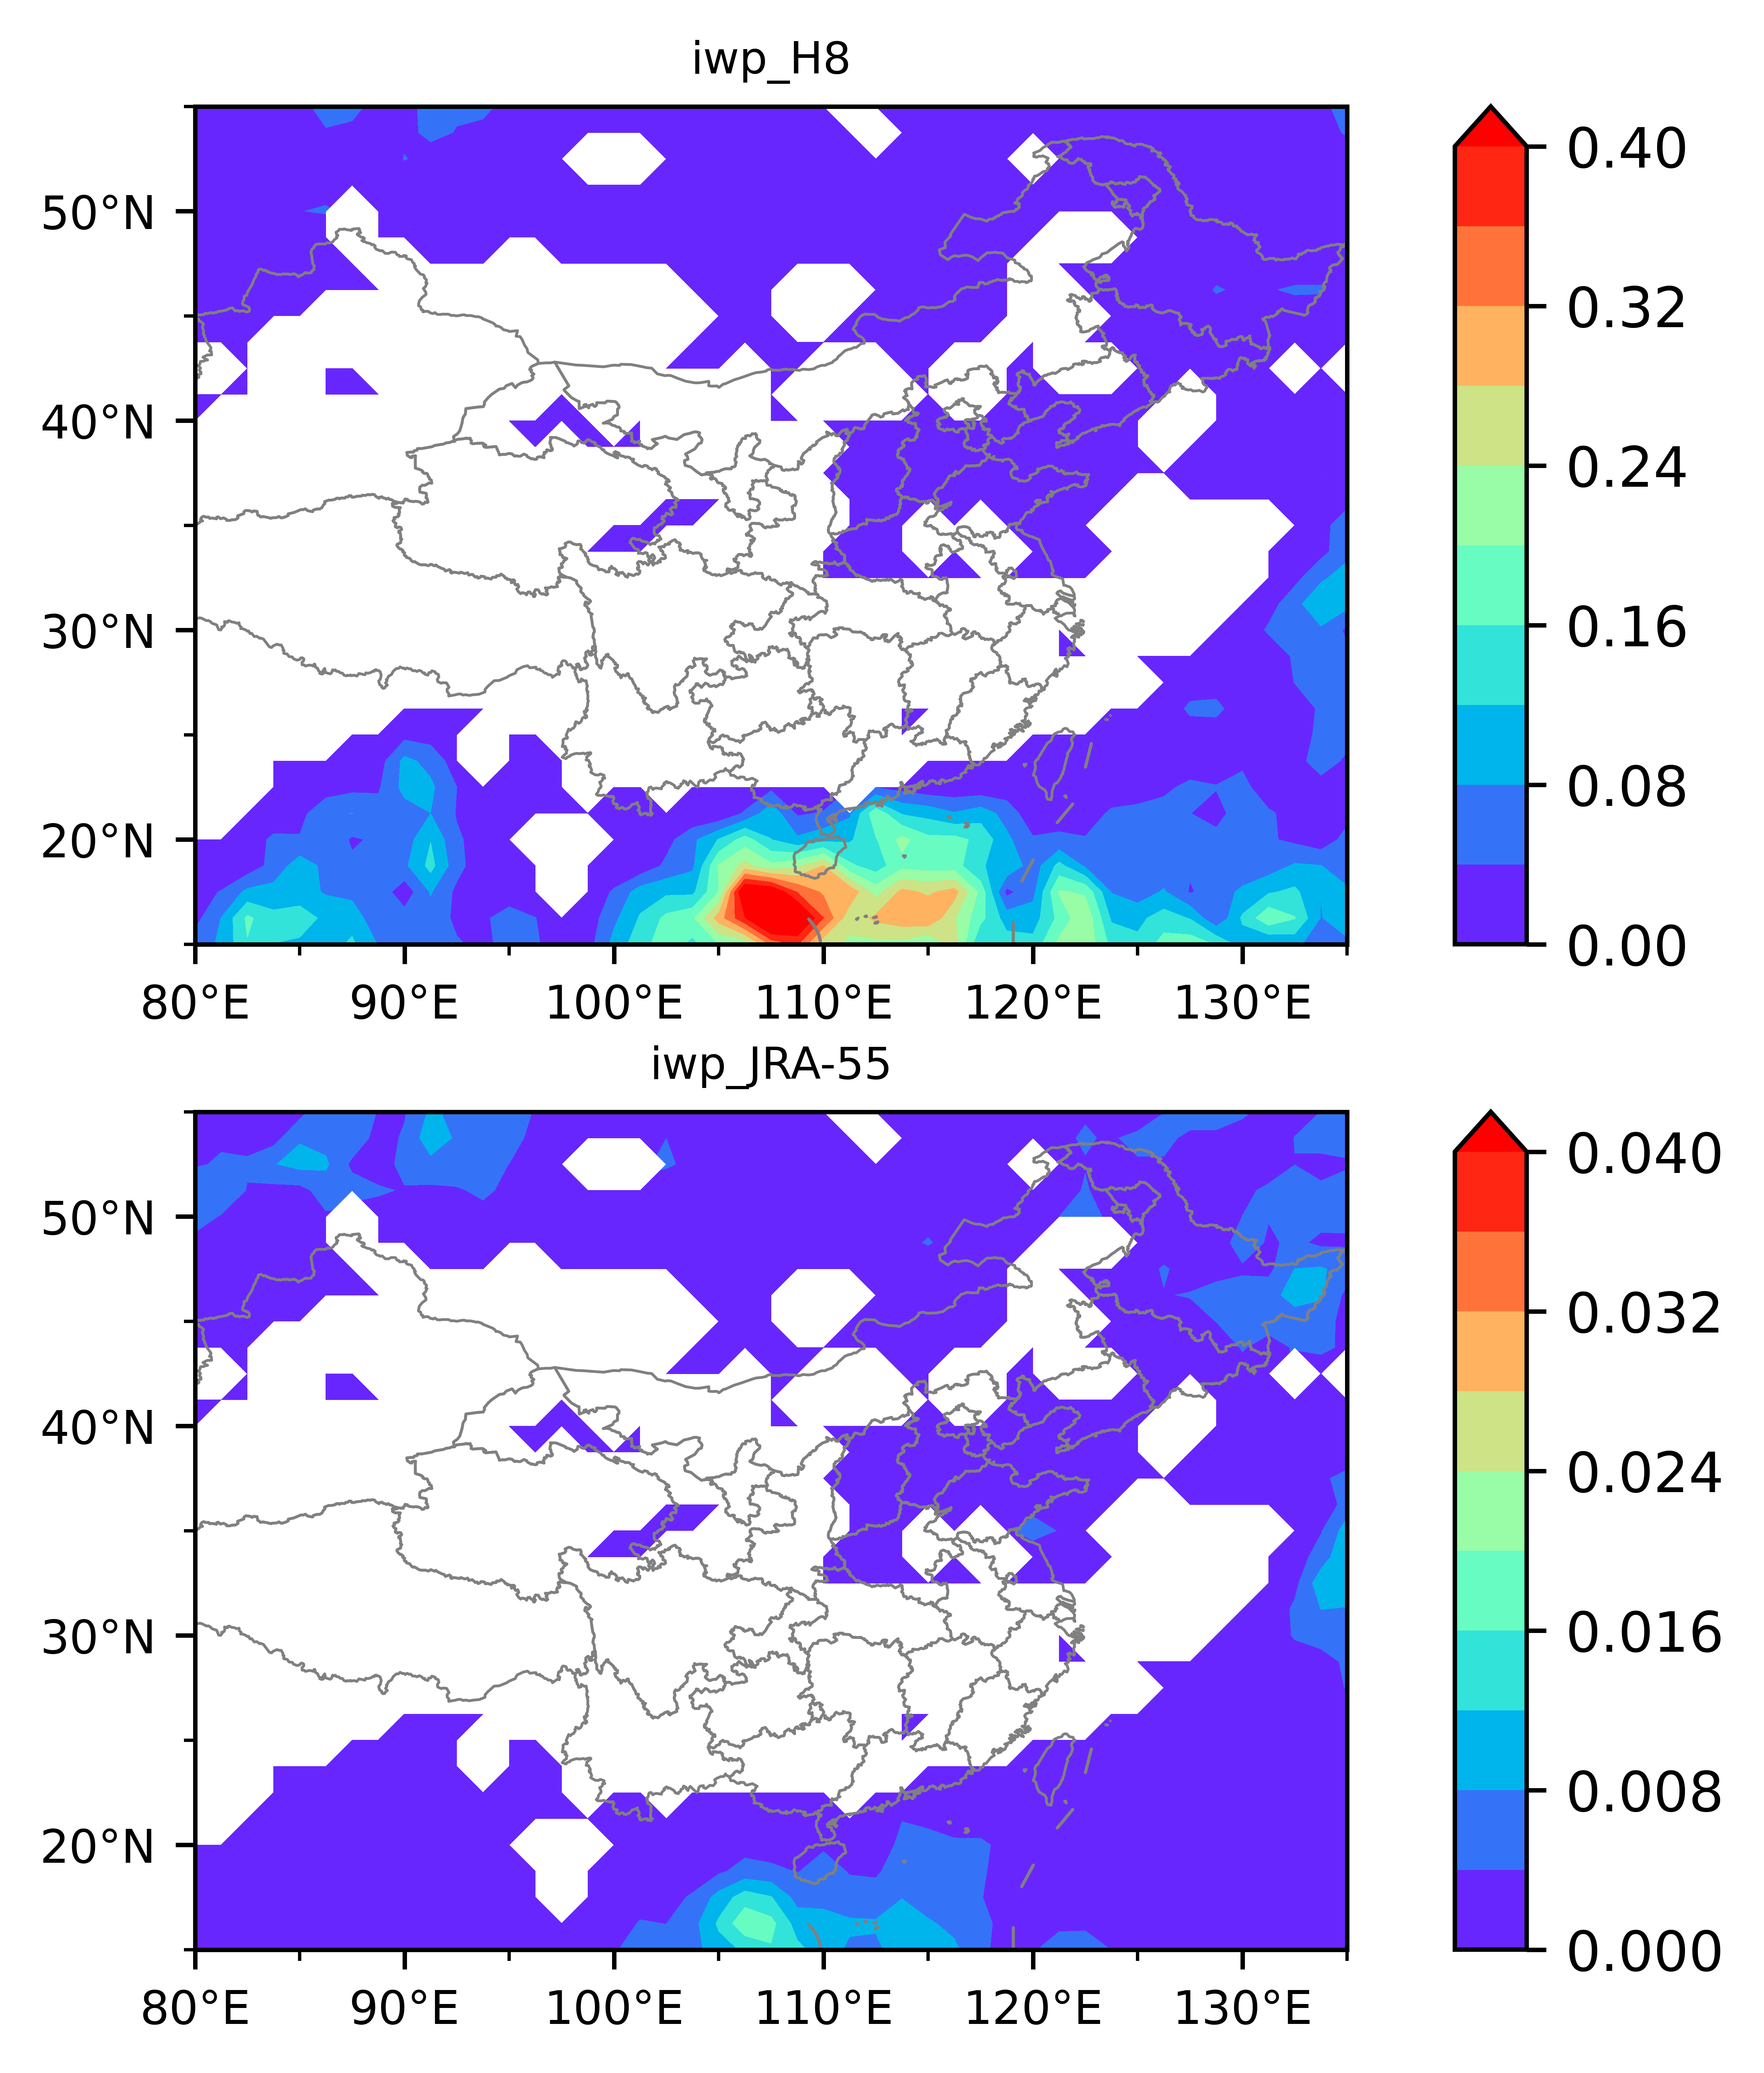

In [34]:
Plot_ComparedPic(x, y, H8array_iwp, ERA5array_iwp, 'origin_iwp_10', 'iwp_H8', 'iwp_JRA-55', 'rainbow', decascale=True)

value_max:0.037198341498940676, value_min:0.0
level_limit : 0.0
level_limit : 0.03
level: 2


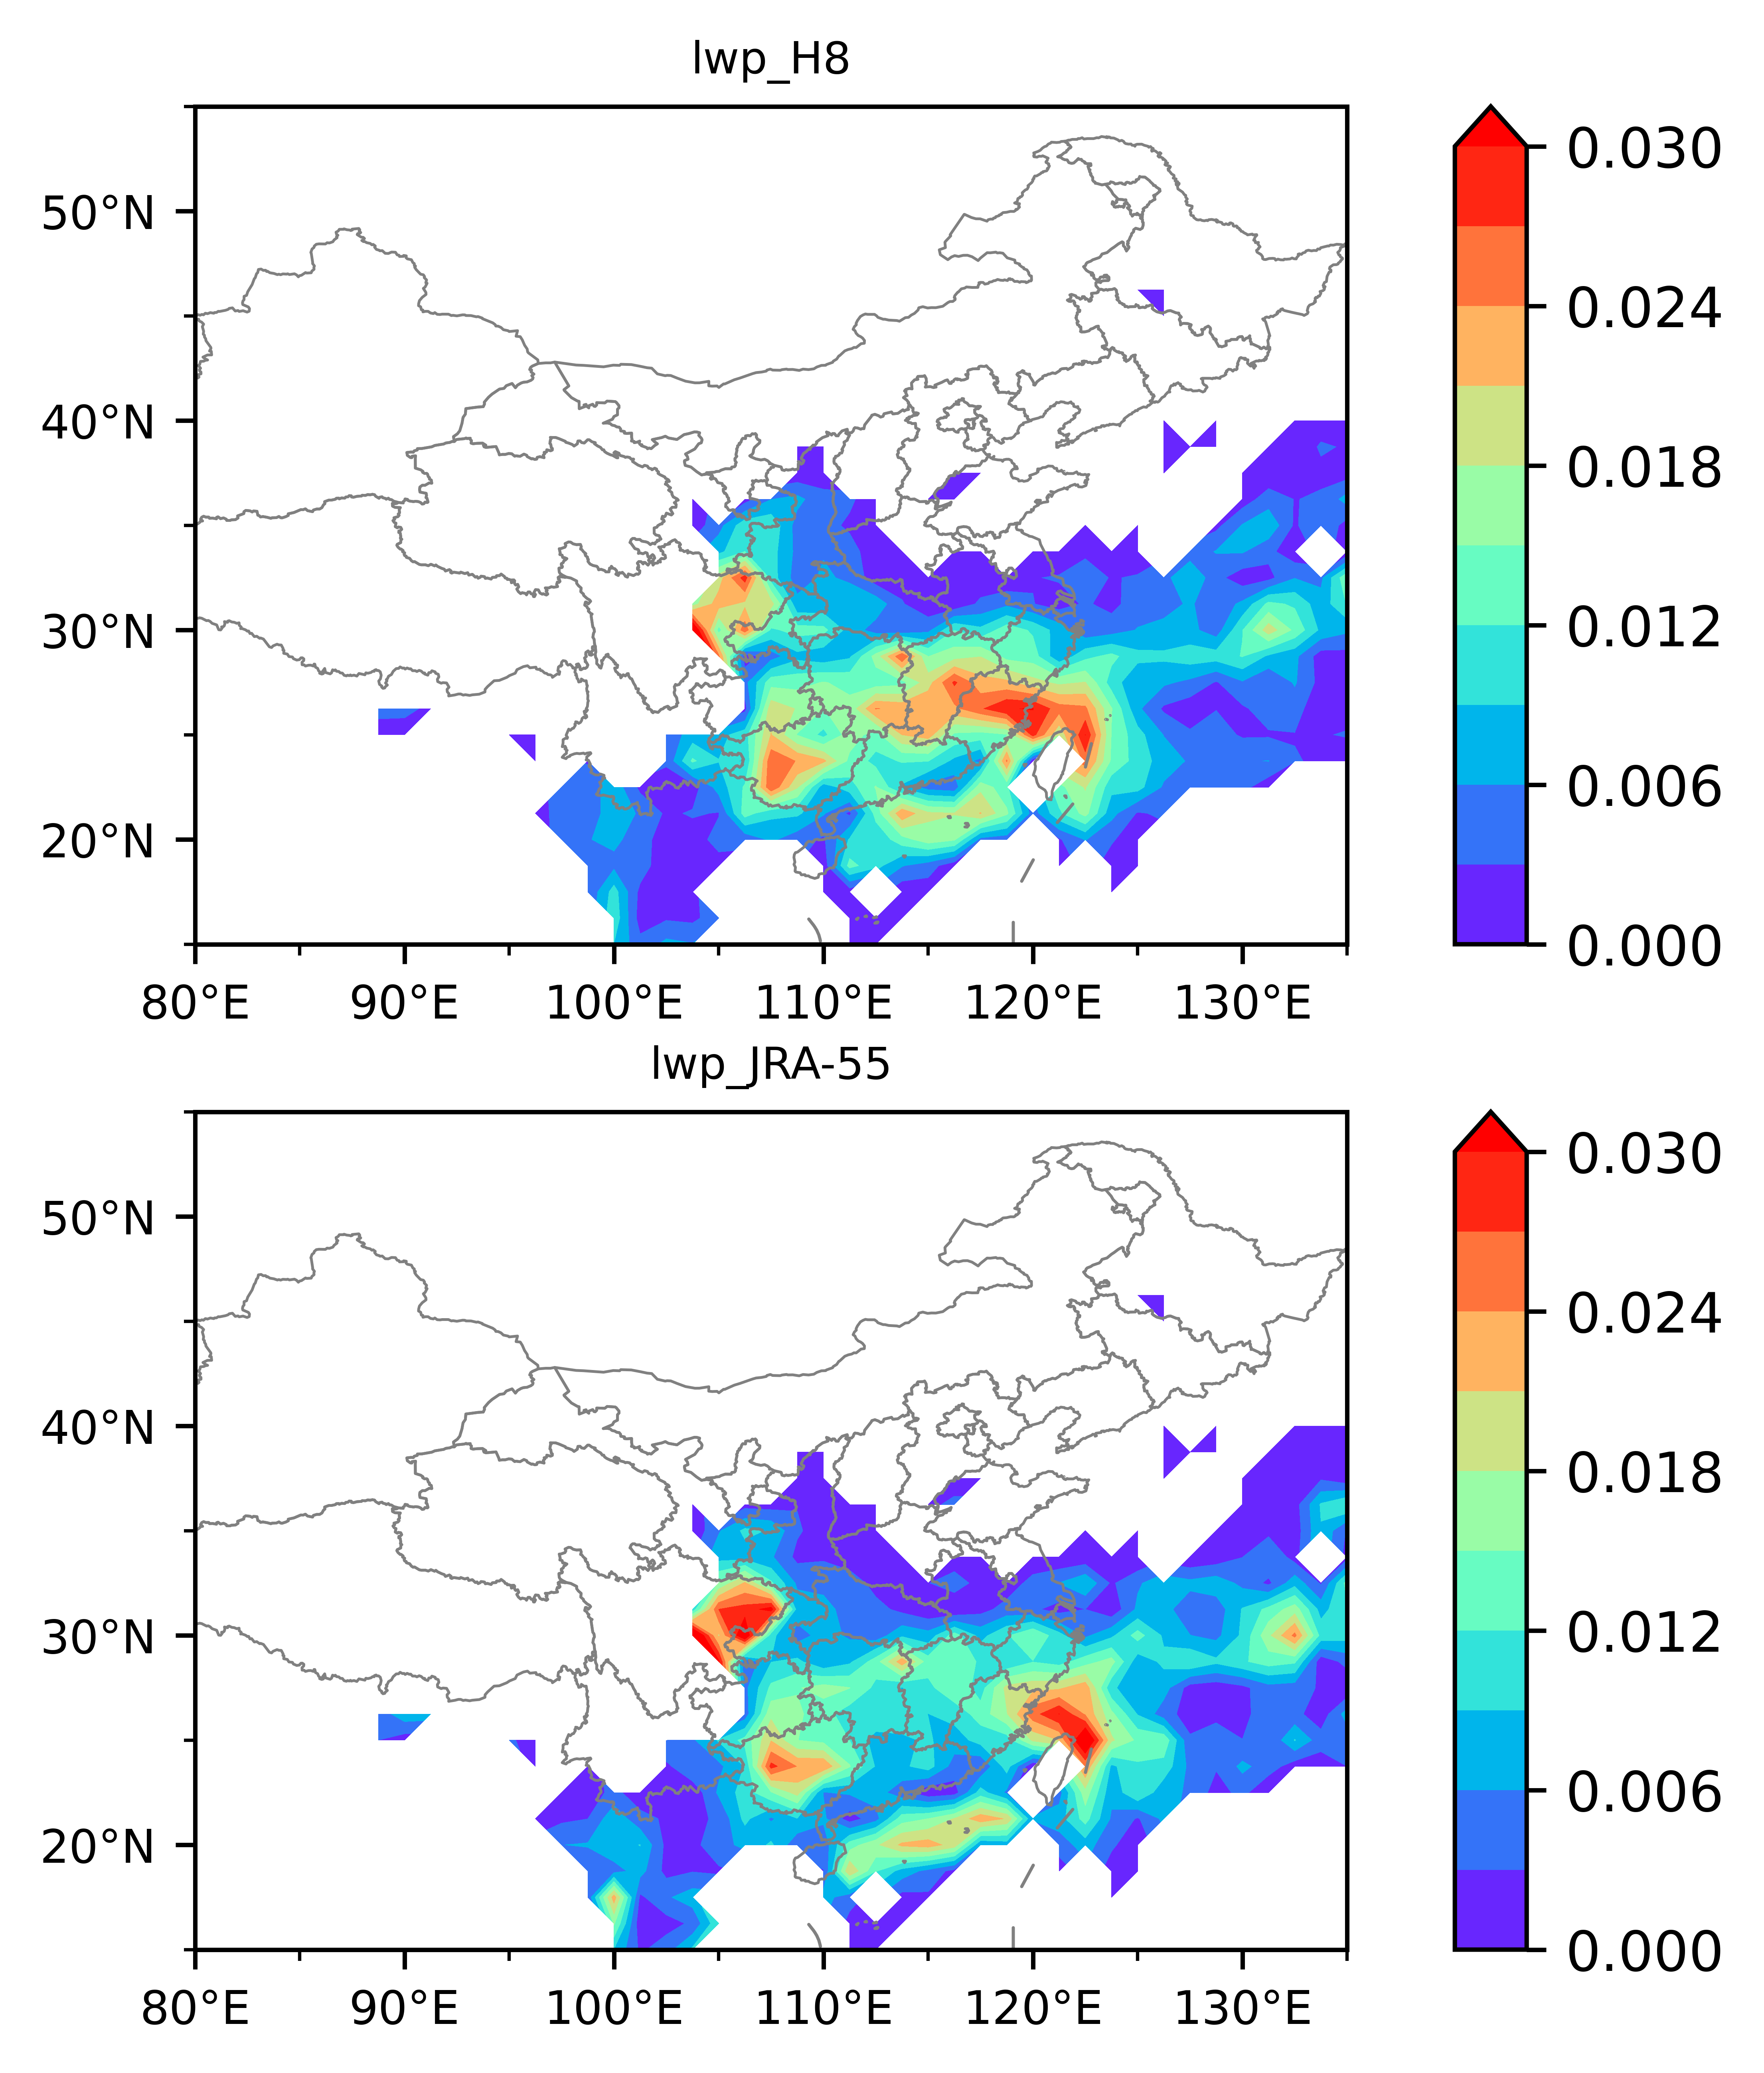

In [35]:
Plot_ComparedPic(x, y, H8array_lwp, ERA5array_lwp, 'origin_lwp_10', 'lwp_H8', 'lwp_JRA-55', 'rainbow')

value_max:0.012306426375219429, value_min:-0.4934444126402597
level_limit : 0.4
level: 1


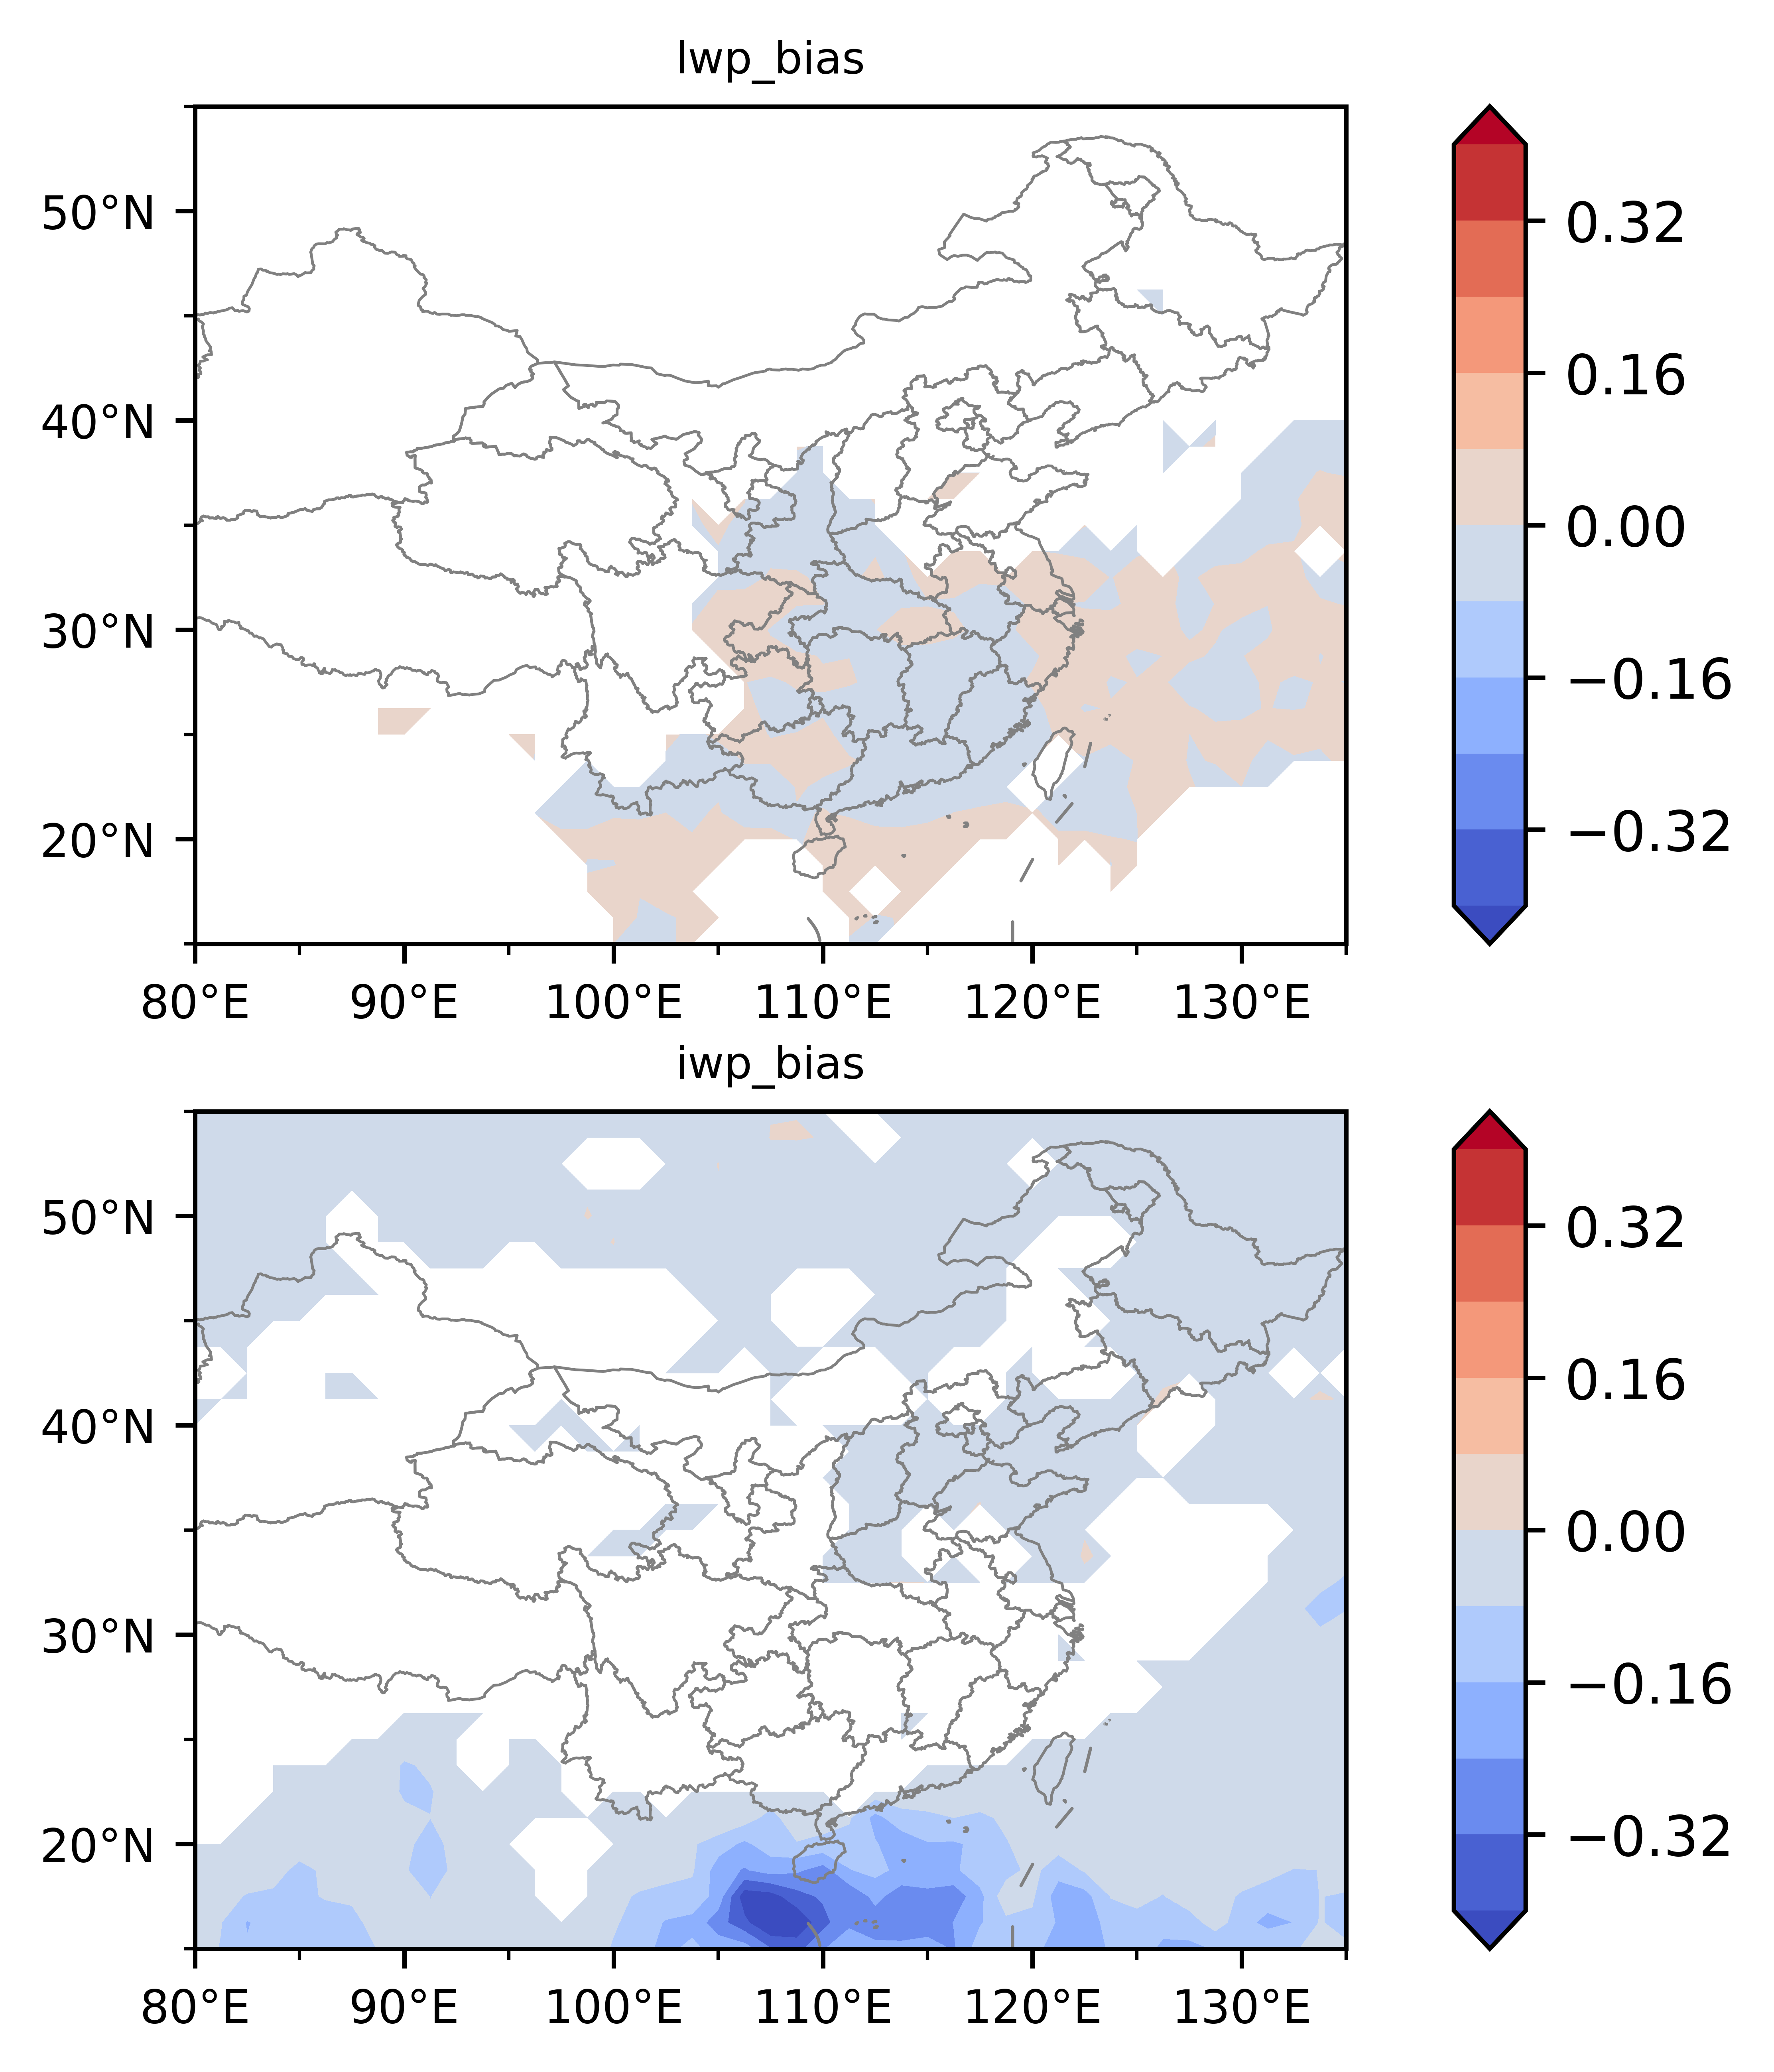

In [36]:
Plot_ComparedPic(x, y, array_Biaslwp, array_Biasiwp, 'bias_lwp_01', 'lwp_bias', 'iwp_bias', 'coolwarm', directionLevels=False)

### 由于1月份的JRA55_surecloud的数据缺失一个时次，因此时间总数均少一

In [18]:
valid_Biaslwpdata = np.empty([0])
valid_Biasiwpdata = np.empty([0])
for itime in range(H8_CLW_CHN.shape[2]-1):
    onetimedata_lwp = Bias_lwp[:,:,itime]
    onetimedata_iwp = Bias_iwp[:,:,itime]
    valid_Biaslwpdata = \
    np.hstack([valid_Biaslwpdata,onetimedata_lwp[onetimedata_lwp != -327]])
    valid_Biasiwpdata = \
    np.hstack([valid_Biasiwpdata,onetimedata_iwp[onetimedata_iwp != -327]])

STD_lwp = np.std(valid_Biaslwpdata)
# STD_iwp = np.std(valid_Biasiwpdata)
MEAN_lwp = np.mean(valid_Biaslwpdata)
# MEAN_iwp = np.mean(valid_Biasiwpdata)
RMSE_lwp = np.sqrt(sum(valid_Biaslwpdata**2)/len(valid_Biaslwpdata))
# RMSE_iwp = np.sqrt(sum(valid_Biasiwpdata**2)/len(valid_Biasiwpdata))

In [19]:
# print(RMSE_lwp, RMSE_iwp)
# print(STD_lwp, STD_iwp)
# print(MEAN_lwp, MEAN_iwp)
print(RMSE_lwp, STD_lwp, MEAN_lwp)

0.1348727048391172 0.13483480923469018 -0.0031969875295854624


In [20]:
#计算云水、云冰在空间上的分布情况，月平均值
# def Get_stack(dataset, looptime):
#     data_stack = np.zeros([161, 221, looptime])
#     Countvalid_stack = np.zeros([161, 221])
#     for itime in range(looptime):
#         onetimedata = dataset[:,:,itime]
#         Countvalid_stack[onetimedata != -327] += 1
#         data_stack[:,:,itime][onetimedata != -327] = onetimedata[onetimedata != -327]
#     return data_stack.sum(axis=2), Countvalid_stack

# stack_lwparray, Countvalid_stack_lwp= Get_stack(dataset.Bias_lwp.data, dataset.dims['time'])
# stack_iwparray, Countvalid_stack_iwp= Get_stack(dataset.Bias_iwp.data, dataset.dims['time'])



C:\Users\Administrator\AppData\Local\Temp\ipykernel_12124\3782995766.py:27: RuntimeWarning: invalid value encountered in true_divide
  Mean_sum1 = data_stack1.sum(axis=2)/Countvalid_stack
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12124\3782995766.py:28: RuntimeWarning: invalid value encountered in true_divide
  Mean_sum2 = data_stack2.sum(axis=2)/Countvalid_stack


In [21]:
array_Biaslwp = ERA5array_lwp - H8array_lwp
array_Biasiwp = ERA5array_iwp - H8array_iwp

In [22]:
Biaslwp_f = array_Biaslwp.flatten()
Biaslwp_n = Biaslwp_f[~np.isnan(Biaslwp_f)]
np.mean(Biaslwp_n), np.sqrt(np.sum(Biaslwp_n**2)/len(Biaslwp_n)), np.std(Biaslwp_n)

(-0.015249740517788777, 0.07251961188922479, 0.0708980925180918)

DriverError: 'D:\\Yu_jie\\python project\\python_qixianglianxi\\shp\\China\\china.shp' does not exist in the file system, and is not recognized as a supported dataset name.

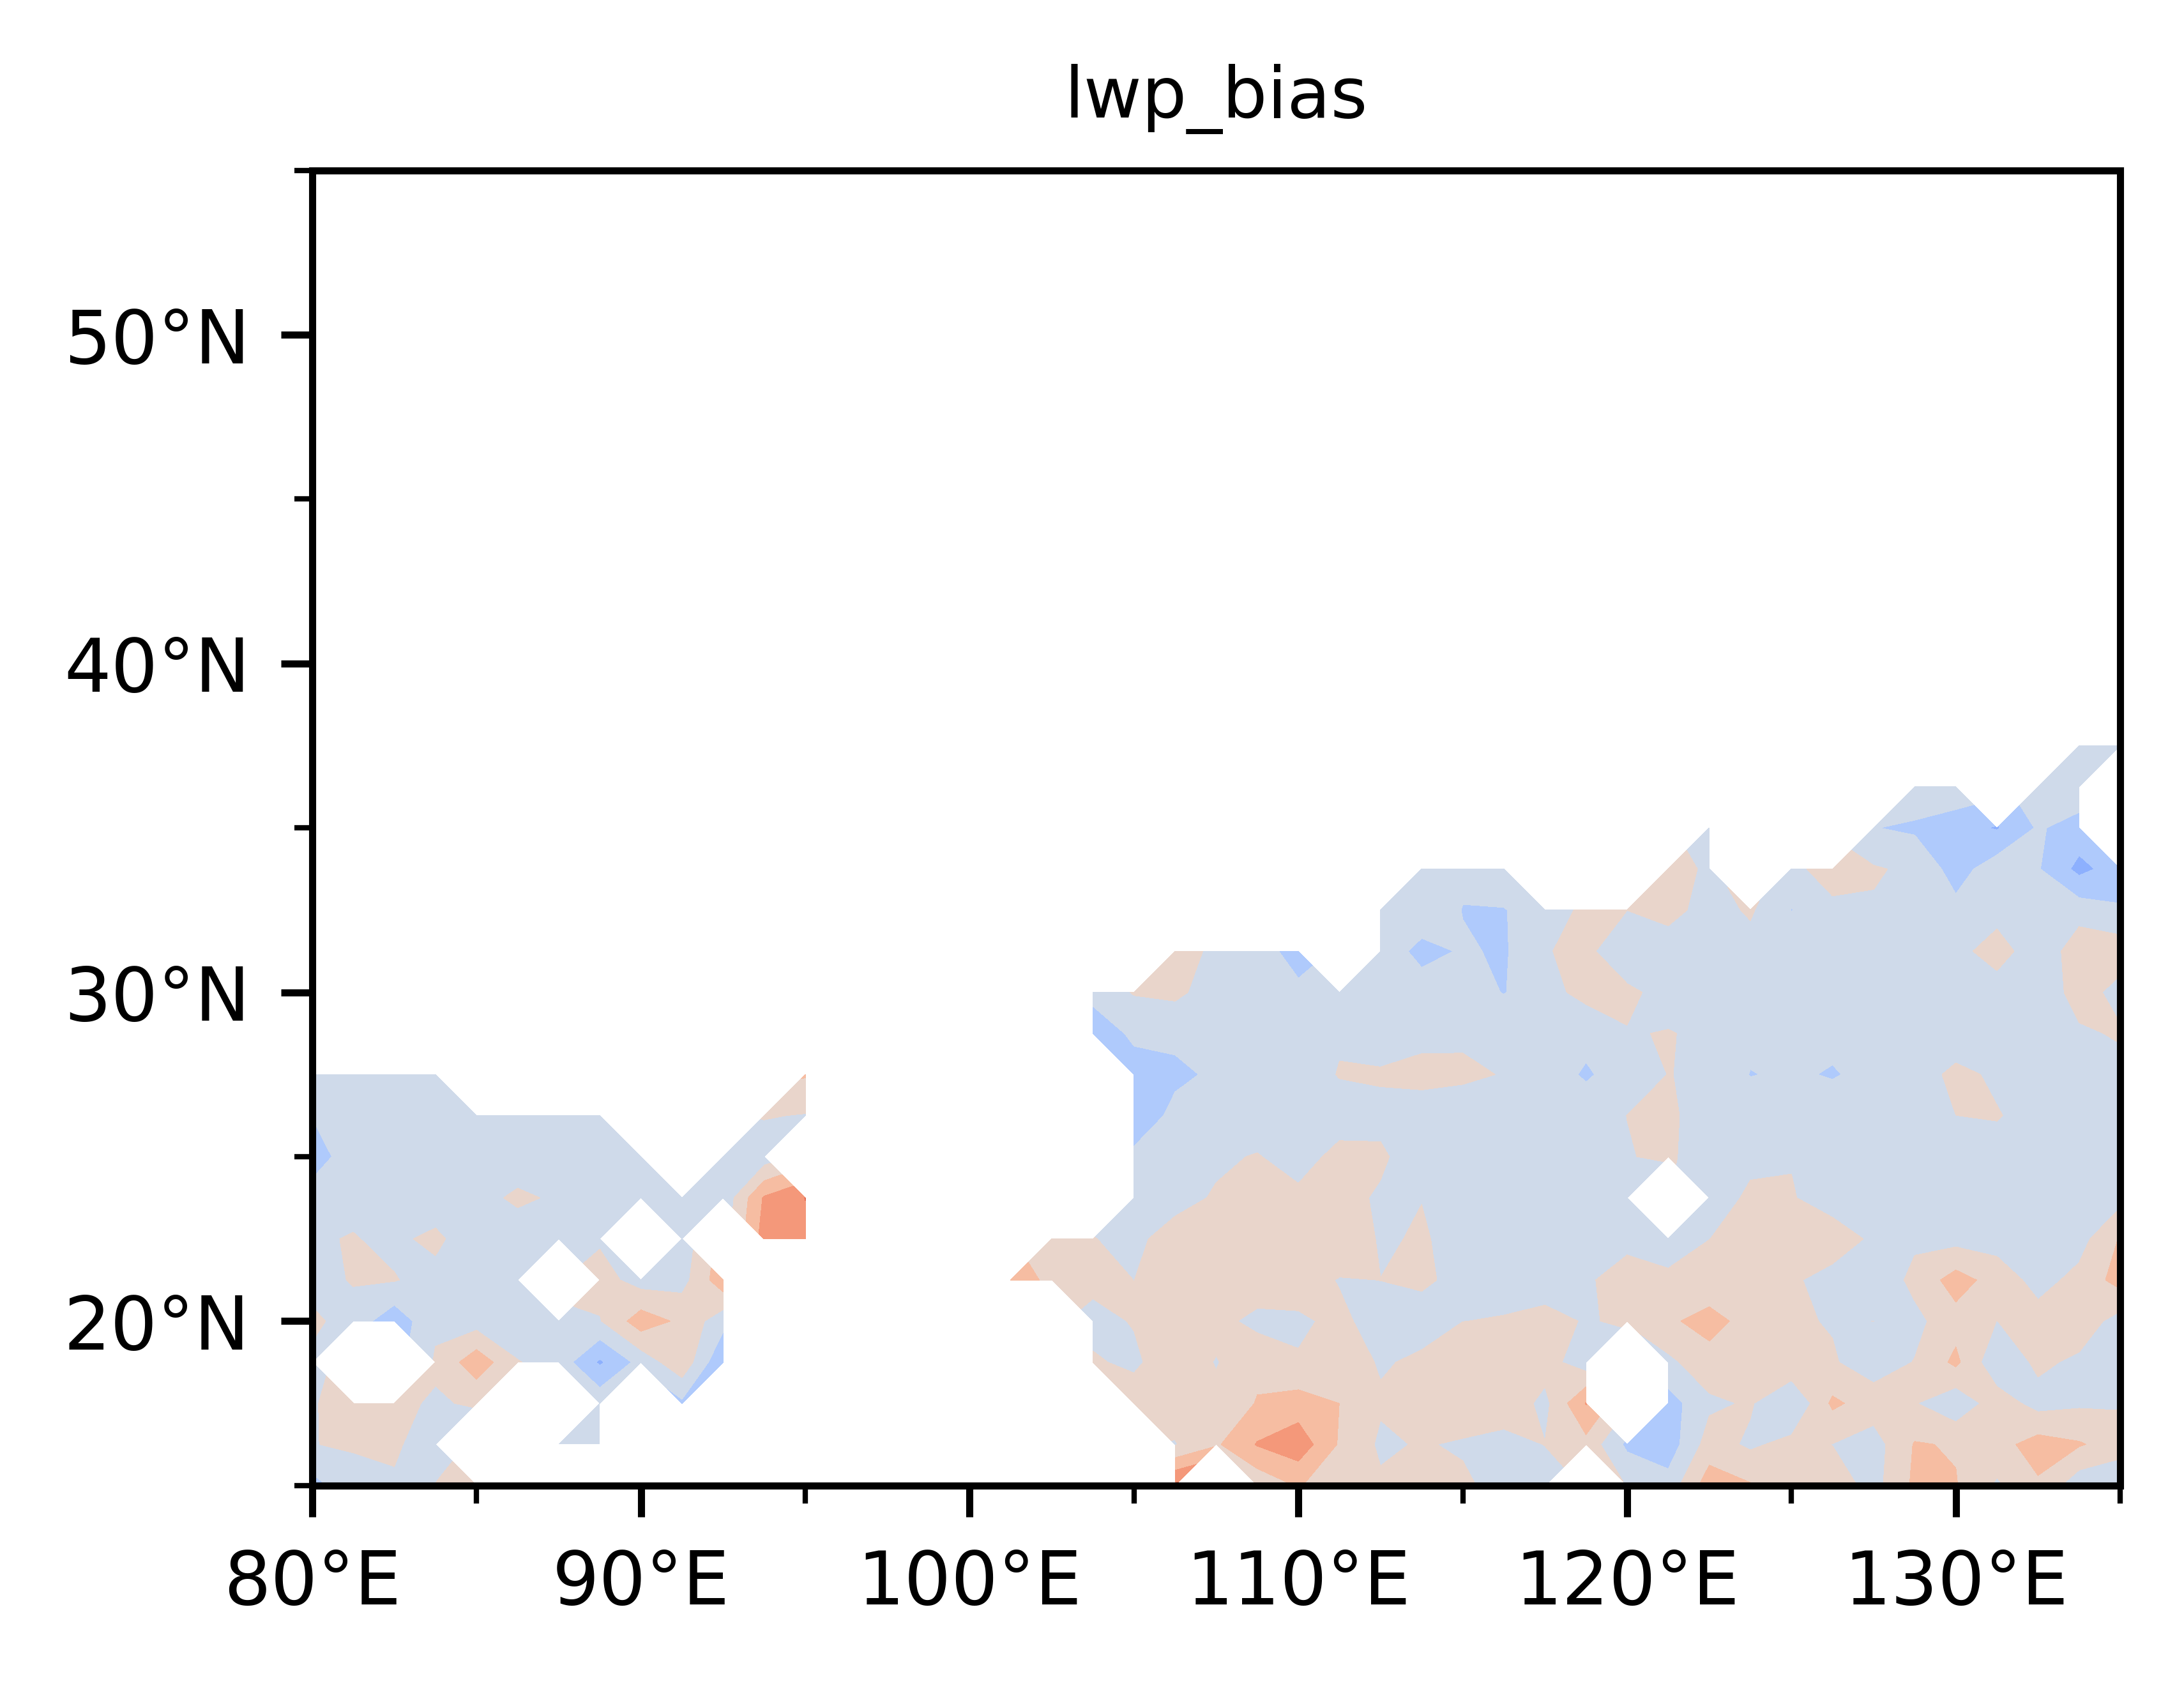

In [26]:
# Plot_2_pic(array_Biaslwp, array_Biasiwp, 'bias_lwp_01', 'lwp_bias', 'iwp_bias', 'coolwarm')
Plot_2_pic(array_Biaslwp, array_Biaslwp, 'bias_lwp_01', 'lwp_bias', 'iwp_bias', 'coolwarm')

In [27]:
def Plot_22_pic(data1, data2, picname, title1, title2, colorp):
    extent = [80, 135, 15, 55]#100E--110E,25N--35N
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    fig = plt.figure(figsize=(9,6), dpi=1000)
    ax1 = fig.add_subplot(211, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax1, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)
    ax1.set_title(title1, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
#     levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    levels = np.linspace(0, 0.6, 11)
    im1 = ax1.contourf(X, Y, data1, cmap = colorp, levels = levels, extend='max')
    add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax1 = fig.add_axes([ax1.get_position().x1 + 0.03, ax1.get_position().y0, 0.02, ax1.get_position().height])
    plt.colorbar(im1, cax=cax1)

    ax2 = fig.add_subplot(212, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax2.set_extent(extent, crs=proj)
    ax2.set_title(title2, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
    levels = np.linspace(0, 0.6, 11)
#     levels = np.linspace(0, 0.1, 11)
    im2 = ax2.contourf(X, Y, data2, cmap = colorp, levels = levels, extend='max')
    add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax2 = fig.add_axes([ax2.get_position().x1 + 0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
    plt.colorbar(im2, cax=cax2)
#     plt.savefig(f'D:/python project/python_qixianglianxi/ZiYuanPingGu/analyze_draw/{picname}.png',
#                 dpi=100,
#                 bbox_inches = 'tight'
#     #             facecolor = 'g',
#     #             edgecolor = 'b'
#                )
    plt.show()

DriverError: 'D:\\Yu_jie\\python project\\python_qixianglianxi\\shp\\China\\china.shp' does not exist in the file system, and is not recognized as a supported dataset name.

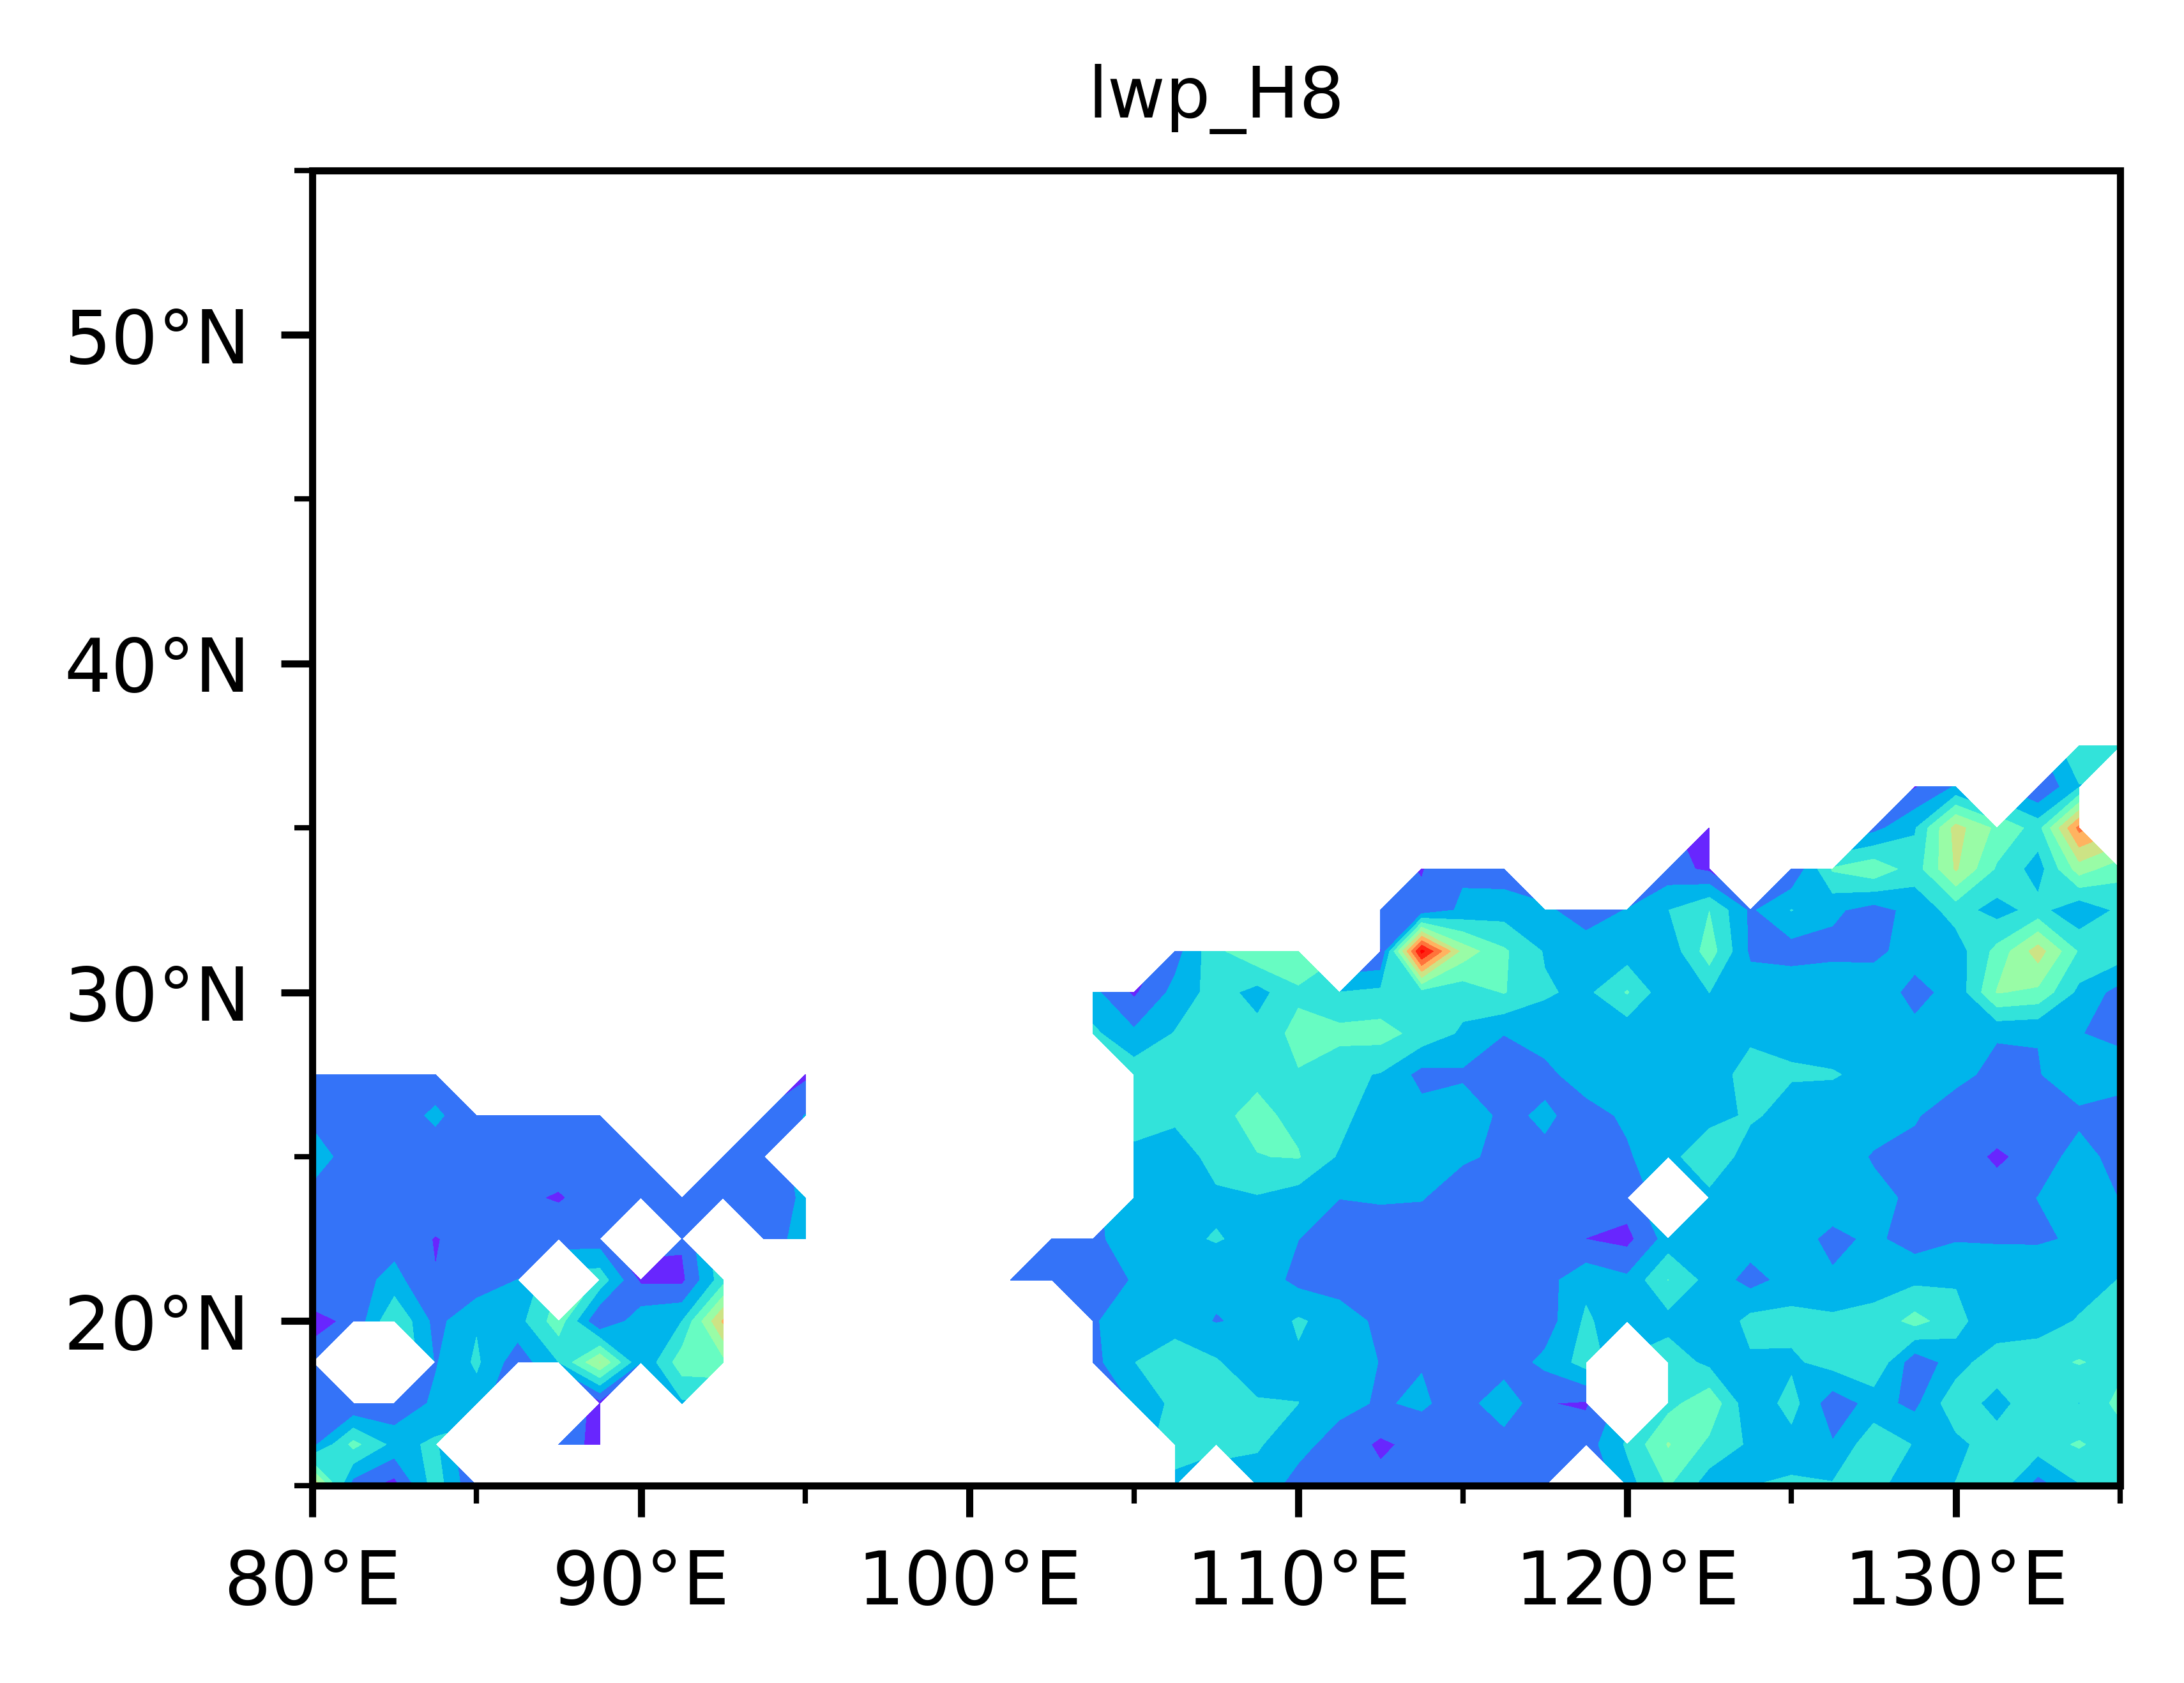

In [28]:
Plot_22_pic(H8array_lwp, ERA5array_lwp, 'origin_lwp_10', 'lwp_H8', 'lwp_JRA55', 'rainbow')

In [ ]:
# Plot_22_pic(H8array_iwp, ERA5array_iwp, 'origin_iwp_10', 'iwp_H8', 'iwp_JRA55', 'rainbow')

In [29]:
ds = xr.open_dataset(r'E:\ZiYuanPingGu\result2\01.nc')
ds

<xarray.Dataset>
Dimensions:         (lat: 161, lon: 221, ERA5_ym2: 40, ERA5_eb1: 40,
                     ERA5_eb2: 40, lat2: 81, lon2: 111, MERRA2_ym1: 40,
                     MERRA2_ym2: 40, MERRA2_eb1: 40, MERRA2_eb2: 40, lat1: 33,
                     lon1: 45, JRA55_ym1: 40, JRA55_ym2: 40, JRA55_eb1: 40,
                     JRA55_eb2: 40)
Coordinates:
  * ERA5_ym2        (ERA5_ym2) float64 -0.015 -0.0339 ... -0.9523 -0.9823
  * ERA5_eb1        (ERA5_eb1) float64 0.1096 0.1215 0.1449 ... 0.1512 0.1088
  * ERA5_eb2        (ERA5_eb2) float64 0.0148 0.0094 0.0115 ... 0.0199 0.0051
  * MERRA2_ym1      (MERRA2_ym1) float64 0.0261 0.0292 0.0243 ... nan nan
  * MERRA2_ym2      (MERRA2_ym2) float64 -0.0236 nan -0.0674 ... -0.9336 nan nan
  * MERRA2_eb1      (MERRA2_eb1) float64 0.0509 0.0669 0.0722 ... 0.0 nan nan
  * MERRA2_eb2      (MERRA2_eb2) float64 0.0 nan 0.0038 0.0 ... nan 0.0 nan nan
  * JRA55_ym1       (JRA55_ym1) float64 0.0445 0.0358 0.0216 ... nan nan nan
  * JRA55_ym2       (JRA55_ym2) float64 nan nan nan nan nan ... nan nan nan nan
  * JRA55_eb1       (JRA55_eb1) float64 0.0718 0.0785 0.0721 ... nan nan nan
  * JRA55_eb2       (JRA55_eb2) float64 nan nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: lat, lon, lat2, lon2, lat1, lon1
Data variables: (12/13)
    ERA5_ym1        int32 ...
    H8_lwp_mm       (lat, lon) float64 ...
    H8_iwp_mm       (lat, lon) float64 ...
    bias_ERA5lwp    (lat, lon) float64 ...
    bias_ERA5iwp    (lat, lon) float64 ...
    ERA5_lwp_mm     (lat, lon) float64 ...
    ...              ...
    bias_MERRA2lwp  (lat2, lon2) float64 ...
    bias_MERRA2iwp  (lat2, lon2) float64 ...
    MERRA2_lwp_mm   (lat2, lon2) float64 ...
    MERRA2_iwp_mm   (lat2, lon2) float64 ...
    bias_JRA55lwp   (lat1, lon1) float64 ...
    JRA55_lwp_mm    (lat1, lon1) float64 ...

In [ ]:
# array_Biaslwp[np.isnan(array_Biaslwp)] = -327
# array_Biasiwp[np.isnan(array_Biasiwp)] = -327

In [32]:
ds['bias_JRA55lwp'] = (('lat1', 'lon1'), array_Biaslwp)
ds['bias_JRA55iwp'] = (('lat1', 'lon1'), array_Biasiwp)
ds['JRA55_lwp_mm'] = (('lat1', 'lon1'), ERA5array_lwp)
ds['JRA55_iwp_mm'] = (('lat1', 'lon1'), ERA5array_iwp)
# ds['JRA55_ym1'] = y_mean1
# ds['JRA55_ym2'] = y_mean2
# ds['JRA55_eb1'] = y_error1
# ds['JRA55_eb2'] = y_error2

In [33]:
ds

<xarray.Dataset>
Dimensions:         (lat: 161, lon: 221, ERA5_ym2: 40, ERA5_eb1: 40,
                     ERA5_eb2: 40, lat2: 81, lon2: 111, MERRA2_ym1: 40,
                     MERRA2_ym2: 40, MERRA2_eb1: 40, MERRA2_eb2: 40, lat1: 33,
                     lon1: 45, JRA55_ym1: 40, JRA55_ym2: 40, JRA55_eb1: 40,
                     JRA55_eb2: 40)
Coordinates:
  * ERA5_ym2        (ERA5_ym2) float64 -0.015 -0.0339 ... -0.9523 -0.9823
  * ERA5_eb1        (ERA5_eb1) float64 0.1096 0.1215 0.1449 ... 0.1512 0.1088
  * ERA5_eb2        (ERA5_eb2) float64 0.0148 0.0094 0.0115 ... 0.0199 0.0051
  * MERRA2_ym1      (MERRA2_ym1) float64 0.0261 0.0292 0.0243 ... nan nan
  * MERRA2_ym2      (MERRA2_ym2) float64 -0.0236 nan -0.0674 ... -0.9336 nan nan
  * MERRA2_eb1      (MERRA2_eb1) float64 0.0509 0.0669 0.0722 ... 0.0 nan nan
  * MERRA2_eb2      (MERRA2_eb2) float64 0.0 nan 0.0038 0.0 ... nan 0.0 nan nan
  * JRA55_ym1       (JRA55_ym1) float64 0.0445 0.0358 0.0216 ... nan nan nan
  * JRA55_ym2       (JRA55_ym2) float64 nan nan nan nan nan ... nan nan nan nan
  * JRA55_eb1       (JRA55_eb1) float64 0.0718 0.0785 0.0721 ... nan nan nan
  * JRA55_eb2       (JRA55_eb2) float64 nan nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: lat, lon, lat2, lon2, lat1, lon1
Data variables: (12/15)
    ERA5_ym1        int32 0
    H8_lwp_mm       (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.1077 0.1115 0.1185
    H8_iwp_mm       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bias_ERA5lwp    (lat, lon) float64 0.03419 0.03473 ... -0.05899 -0.07105
    bias_ERA5iwp    (lat, lon) float64 0.02729 0.02996 ... 0.01883 0.03134
    ERA5_lwp_mm     (lat, lon) float64 0.03419 0.03473 ... 0.05253 0.04744
    ...              ...
    MERRA2_lwp_mm   (lat2, lon2) float64 0.03459 0.03081 ... 0.0946 0.05994
    MERRA2_iwp_mm   (lat2, lon2) float64 0.002037 0.001385 ... 1.739e-09
    bias_JRA55lwp   (lat1, lon1) float64 nan nan nan ... -0.06612 -0.09872
    JRA55_lwp_mm    (lat1, lon1) float64 nan nan nan ... 0.1782 0.1099 0.09473
    bias_JRA55iwp   (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan
    JRA55_iwp_mm    (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan

In [34]:
ds.close()

In [35]:
ds.to_netcdf('E:/ZiYuanPingGu/result2/01.nc')